In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, LogNorm
from scipy.constants import mu_0
import discretize
import time
import ipywidgets

from simpeg import maps, utils
from simpeg.electromagnetics import time_domain as tdem

import casing_utils

In [2]:
Solver = utils.solver_utils.get_default_solver()

In [3]:
sigma_back = 1e-1
sigma_air = 1e-4

casing_b = 5e-2
casing_a = 4e-2

casing_l = 30

sigma_casing = 5e6

mur_casing = 100

src_z = np.r_[0, -100]

In [4]:
rx_x = np.arange(10, 101)[::2] + 0.5
rx_x

array([ 10.5,  12.5,  14.5,  16.5,  18.5,  20.5,  22.5,  24.5,  26.5,
        28.5,  30.5,  32.5,  34.5,  36.5,  38.5,  40.5,  42.5,  44.5,
        46.5,  48.5,  50.5,  52.5,  54.5,  56.5,  58.5,  60.5,  62.5,
        64.5,  66.5,  68.5,  70.5,  72.5,  74.5,  76.5,  78.5,  80.5,
        82.5,  84.5,  86.5,  88.5,  90.5,  92.5,  94.5,  96.5,  98.5,
       100.5])

In [5]:
pf = 1.3

csz = 1
npadz = 28
n_core_z = int(np.max(np.abs(src_z))/csz)
hz = discretize.utils.unpack_widths([(csz, npadz, -pf), (csz, n_core_z), (csz, npadz, pf)])

npadx = npadz

hx = casing_utils.pad_for_casing_and_data(
    casing_b, 
    csx1=(casing_b - casing_a)/4,
    csx2=1, #csz, 
    pfx1=pf, 
    pfx2=pf, 
    domain_x=np.max(rx_x), 
    npadx=npadx
)
mesh = discretize.CylindricalMesh(
    [hx, [np.pi*2], hz], origin=np.r_[0, 0, -np.sum(hz[:npadz+n_core_z])]
)

<Axes: xlabel='x', ylabel='z'>

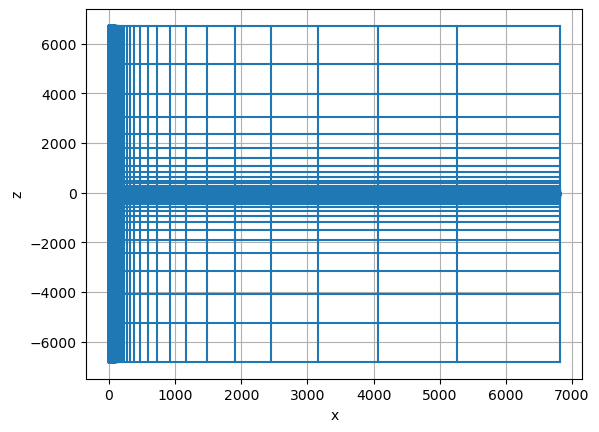

In [6]:
mesh.plot_grid()

In [7]:
sigma_solid = sigma_casing * (casing_b**2 -casing_a**2) / casing_b**2

In [8]:
models = {}
mur_models = {}

sigma = np.ones(mesh.n_cells) * sigma_air
sigma[mesh.cell_centers[:, 2] < 0] = sigma_back

mur_halfspace = np.ones(mesh.n_cells)

models["halfspace"] = sigma
mur_models["halfspace"] = mur_halfspace

inds_outer_casing = (
    (mesh.cell_centers[:, 0] < casing_b) &
    (mesh.cell_centers[:, 2] < 0) & 
    (mesh.cell_centers[:, 2] > -casing_l)
)
sigma_cylinder = sigma.copy()
sigma_cylinder[inds_outer_casing] = sigma_solid

models["solid"] = sigma_cylinder

mur_cylinder = mur_halfspace.copy()
mur_cylinder[inds_outer_casing] = mur_casing
mur_models["solid"] = mur_cylinder

inds_casing = (
    inds_outer_casing & 
    (mesh.cell_centers[:, 0] > casing_a)
)
sigma_hollow = sigma.copy()
sigma_hollow[inds_casing] = sigma_casing
models["casing"] = sigma_hollow

mur_hollow = mur_halfspace.copy()
mur_hollow[inds_casing] = mur_casing
mur_models["casing"] = mur_hollow

In [9]:
keys = list(models.keys())
keys

['halfspace', 'solid', 'casing']

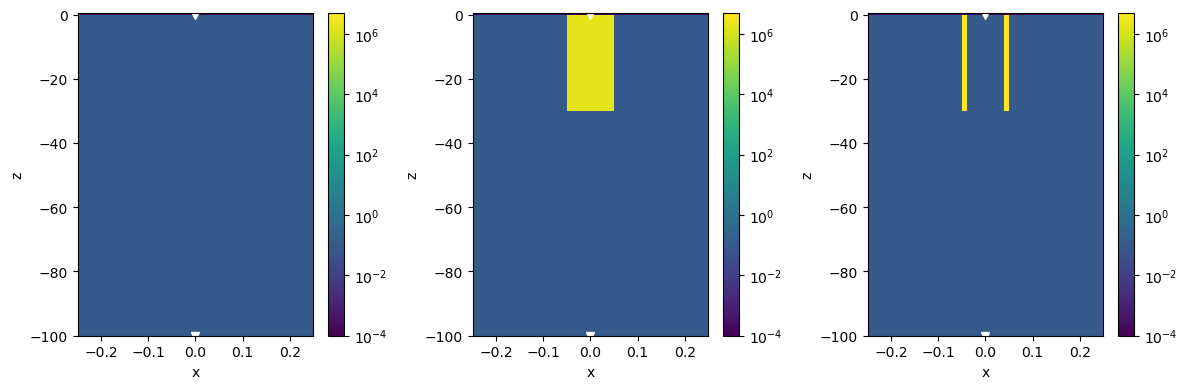

In [10]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))

for a, key in zip(ax, keys): 
    plt.colorbar(mesh.plot_image(
        models[key],
        pcolor_opts={"norm":LogNorm(vmin=sigma_air, vmax=sigma_casing)},
        mirror=True,
        ax=a,
    )[0], ax=a)


    a.set_xlim(np.r_[-1, 1]*0.25),
    a.set_ylim(np.r_[-100, 0.5])
    a.plot(np.r_[0, 0], src_z, "wv")
plt.tight_layout()

In [11]:
rx_times = np.logspace(-5, 0, 50)

In [16]:
rx_ex = tdem.receivers.PointElectricField(
    locations=discretize.utils.ndgrid(rx_x, np.r_[0], np.r_[-0.25]),
    orientation="x",
    times=rx_times, 
)


src = tdem.sources.LineCurrent(
    receiver_list = [rx_ex],
    location = np.array([
        [0, 0, src_z.min()], 
        [0, 0, src_z.max()], 
    ])
)
    
survey = tdem.Survey([src])

In [17]:
time_steps = [
    (1e-6, 20),
    (3e-6, 20),
    (1e-5, 20), 
    (3e-5, 20), 
    (1e-4, 20), 
    (3e-4, 20),
    (1e-3, 20), 
    (3e-3, 20),
    (1e-2, 20), 
    (3e-2, 25),
    # (1e-1, 6), 
]

In [18]:
sim = tdem.Simulation3DMagneticField(
    mesh=mesh,
    survey=survey, 
    time_steps=time_steps, 
    sigmaMap=maps.IdentityMap(mesh), 
    solver=Solver
)

In [19]:
dpred_conductive = {}
fields_conductive = {}

for key, model in models.items():
    print(f"Starting {key} ...")
    t0 = time.time()
    sim.mu = mu_0
    fields_conductive[key] = sim.fields(model)
    dpred_conductive[key] = sim.dpred(model, f=fields_conductive[key])
    print(f" ... done. Time: {time.time()-t0:1.1e}s")

Starting halfspace ...
 ... done. Time: 3.1e+00s
Starting solid ...
 ... done. Time: 2.9e+00s
Starting casing ...
 ... done. Time: 3.0e+00s


In [20]:
dpred_permeable = {}
fields_permeable = {}

for key, model in models.items():
    print(f"Starting {key} ...")
    t0 = time.time() 
    sim.mu = mur_models[key] * mu_0
    fields_permeable[key] = sim.fields(model)
    dpred_permeable[key] = sim.dpred(model, f=fields_permeable[key])
    print(f" ... done. Time: {time.time()-t0:1.1e}s")

Starting halfspace ...
 ... done. Time: 3.0e+00s
Starting solid ...
 ... done. Time: 2.9e+00s
Starting casing ...
 ... done. Time: 2.9e+00s


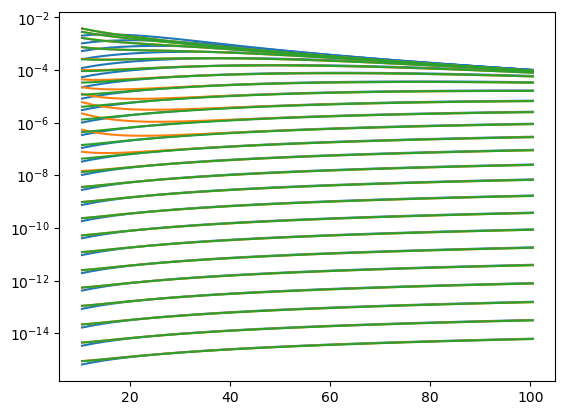

In [21]:
fig, ax = plt.subplots(1, 1)

for i, key in enumerate(keys): 
    ax.semilogy(rx_x, -dpred_conductive[key].reshape(len(rx_times), len(rx_x))[::2, :].T, color=f"C{i}", label=key);


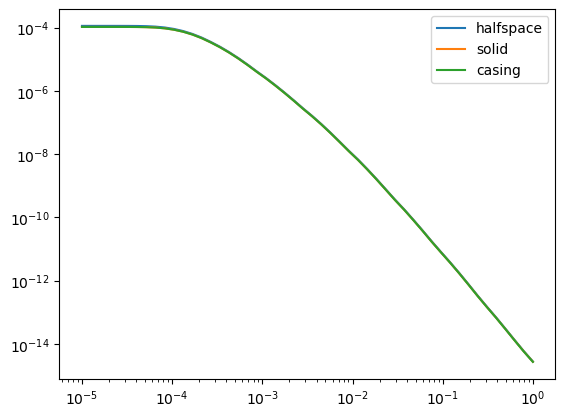

In [22]:
fig, ax = plt.subplots(1, 1)

for i, key in enumerate(keys): 
    ax.loglog(rx_times, -dpred_conductive[key].reshape(len(rx_times), len(rx_x))[:, -3], color=f"C{i}", label=key);
ax.legend()

In [23]:
tind = 0

In [37]:
def plot_currents_all(tind=0, fields=fields_conductive): 
    fig, ax = plt.subplots(1, 3, figsize=(12, 3))
    xlim = np.r_[-1, 1] * 150
    zlim = np.r_[-200, 0.1]

    for a, key in zip(ax, keys[1:]): 
        plotme = mesh.average_face_to_cell_vector * fields[key][:, "j"][:, tind]
        out = mesh.plot_image(
            plotme, v_type="CCv", view="vec", ax=a,
            range_x=xlim, range_y=zlim,
            sample_grid=np.r_[np.diff(xlim)/100., np.diff(zlim)/100.],
            mirror=True, mirror_data=plotme,
            pcolor_opts={"norm":LogNorm()},
            stream_threshold=1e-8,
        )
        plt.colorbar(out[0], ax=a)
        a.set_title(key)

    diff = (
        mesh.average_face_to_cell_vector * fields["solid"][:, "j"][:, tind] - 
        mesh.average_face_to_cell_vector * fields["casing"][:, "j"][:, tind]
    )
    out = mesh.plot_image(
        diff, v_type="CCv", view="vec", ax=ax[2],
        range_x=xlim, range_y=zlim,
        sample_grid=np.r_[np.diff(xlim)/100., np.diff(zlim)/100.],
        mirror=True, mirror_data=diff,
        pcolor_opts={"norm":LogNorm(1e-8, 1e-2)},
        stream_threshold=1e-8,
    )
    plt.colorbar(out[0], ax=ax[2])
    ax[2].set_title("diff")

    for a in ax.flatten(): 
        a.set_aspect(1)
    fig.suptitle(f"t = {sim.times[tind]}")

In [38]:
ipywidgets.interactive(
    plot_currents_all, 
    tind=ipywidgets.IntSlider(vmin=0, vmax=len(sim.times), value=0),
    fields=ipywidgets.fixed(fields_conductive)
)

interactive(children=(IntSlider(value=0, description='tind'), Output()), _dom_classes=('widget-interact',))

In [39]:
ipywidgets.interactive(
    plot_currents_all, 
    tind=ipywidgets.IntSlider(vmin=0, vmax=len(sim.times), value=0),
    fields=ipywidgets.fixed(fields_permeable)
)

interactive(children=(IntSlider(value=0, description='tind'), Output()), _dom_classes=('widget-interact',))